## Eye State Classification from EEG


### Introduction


### Data Prep



In [8]:
# setting the random seed for reproducibility
import random
seed=42
random.seed(seed)

In [9]:
# import libraries 
import itertools
import requests
import os.path
import numpy as np
import pandas as pd
from scipy.io import arff
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

### Load the Data

In [10]:
# check if data file exists locally
if not os.path.isfile('EEG Eye State.arff'):
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00264/EEG%20Eye%20State.arff'
    r = requests.get(url, allow_redirects=True)
    open('EEG Eye State.arff', 'wb').write(r.content)

# read data from local csv file
#df = pd.read_csv("EEGEyeState.csv", header=None)

# read data from local arff file
data = arff.loadarff('EEG Eye State.arff')
df = pd.DataFrame(data[0])

In [11]:
# reject NaN entries
df.dropna()

# insert columns names
df.columns = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4', 'eyeDetection']

# remove outliers
df1 = df[df.loc[:, df.columns != 'eyeDetection'].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis=1)]

# define data samples
X = df1.iloc[0:, 0:14].values

# standardize data
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
X_short = min_max_scaler.fit_transform(X)

# define target
y_short = df1.iloc[0:,14].values.astype(int)

unique, counts = np.unique(y_short, return_counts=True)
print(dict(zip(unique, counts)))

print(df.shape)
print(X_short,X_short.shape,'\n\n',
      y_short,y_short.shape)

{0: 8172, 1: 6720}
(14980, 15)
[[0.43315296 0.42978053 0.53914831 ... 0.44283486 0.52808589 0.51187141]
 [0.41794246 0.41065428 0.56628488 ... 0.43715177 0.51965054 0.48535451]
 [0.4280718  0.41915944 0.57527166 ... 0.4514152  0.50842166 0.49930648]
 ...
 [0.26227399 0.35319255 0.289163   ... 0.3171384  0.4072796  0.36402948]
 [0.2859641  0.35742439 0.31624082 ... 0.36856474 0.41993263 0.3947075 ]
 [0.29609344 0.38086545 0.36745962 ... 0.4085692  0.4241503  0.3947075 ]] (14892, 14) 

 [0 0 0 ... 1 1 1] (14892,)


### Model



In [12]:
# full dataset parameters

# define model parameters
samples = X_short.shape[0]  # how many trials of eeg data
n_features = X_short.shape[1]  # how many channels of eeg in each sample
time_steps = 1 # how many ms was each sample run for

In [13]:
from sklearn.model_selection import StratifiedShuffleSplit

# use strat. shuffle split to get indices for test and training data 
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=seed)
sss.get_n_splits(X_short, y_short)

# take the indices generated by stratified shuffle split and make the test and training datasets
for train_index, test_index in sss.split(X_short, y_short):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X_short[train_index], X_short[test_index]
    y_train, y_test = y_short[train_index], y_short[test_index]
    
X_train = X_train.reshape(X_train.shape[0], time_steps, X_train.shape[1])
y_train = y_train.reshape(y_train.shape[0], time_steps)

X_test = X_test.reshape(X_test.shape[0], time_steps, X_test.shape[1])
y_test = y_test.reshape(y_test.shape[0], time_steps)

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, SimpleRNN
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.regularizers import l1_l2
from keras.callbacks import EarlyStopping, TerminateOnNaN

model = Sequential()
model.add(SimpleRNN(28, return_sequences=True, 
               recurrent_regularizer=l1_l2(0.0001, 0.0001),
               input_shape=(time_steps, n_features)))
model.add(SimpleRNN(28, input_shape=(time_steps, n_features), 
               recurrent_regularizer=l1_l2(0.0001, 0.0001),
               return_sequences=True))
model.add(Dropout(0.5))
model.add(SimpleRNN(28, input_shape=(time_steps, n_features),
              recurrent_regularizer=l1_l2(0.0001, 0.0001)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=0, mode='auto')

terminate_NaN = TerminateOnNaN()

history = model.fit(X_train, y_train, validation_split=0.25, 
                    batch_size=28, epochs=1000, verbose=1, 
                    callbacks=[early_stop, terminate_NaN])

Train on 8934 samples, validate on 2979 samples
Epoch 1/1000
8934/8934 [==============================] - 3s 345us/step - loss: 0.6929 - acc: 0.5630 - val_loss: 0.6605 - val_acc: 0.5844
Epoch 2/1000
8934/8934 [==============================] - 2s 194us/step - loss: 0.6639 - acc: 0.5880 - val_loss: 0.6526 - val_acc: 0.6046
Epoch 3/1000
8934/8934 [==============================] - 2s 195us/step - loss: 0.6556 - acc: 0.6075 - val_loss: 0.6497 - val_acc: 0.6197
Epoch 4/1000
8934/8934 [==============================] - 2s 194us/step - loss: 0.6570 - acc: 0.6103 - val_loss: 0.6508 - val_acc: 0.6056
Epoch 5/1000
8934/8934 [==============================] - 2s 193us/step - loss: 0.6510 - acc: 0.6167 - val_loss: 0.6793 - val_acc: 0.5472
Epoch 6/1000
8934/8934 [==============================] - 2s 196us/step - loss: 0.6510 - acc: 0.6157 - val_loss: 0.7078 - val_acc: 0.5824
Epoch 7/1000
8934/8934 [==============================] - 2s 191us/step - loss: 0.6505 - acc: 0.6230 - val_loss: 0.6476 - va

Epoch 118/1000
8934/8934 [==============================] - 2s 207us/step - loss: 0.5137 - acc: 0.7635 - val_loss: 0.4666 - val_acc: 0.7932
Epoch 119/1000
8934/8934 [==============================] - 2s 209us/step - loss: 0.5158 - acc: 0.7568 - val_loss: 0.4771 - val_acc: 0.7828
Epoch 120/1000
8934/8934 [==============================] - 2s 205us/step - loss: 0.5195 - acc: 0.7544 - val_loss: 0.5225 - val_acc: 0.7553
Epoch 121/1000
8934/8934 [==============================] - 2s 206us/step - loss: 0.5174 - acc: 0.7608 - val_loss: 0.4700 - val_acc: 0.7885
Epoch 122/1000
8934/8934 [==============================] - 2s 213us/step - loss: 0.5182 - acc: 0.7599 - val_loss: 0.4663 - val_acc: 0.7899
Epoch 123/1000
8934/8934 [==============================] - 2s 208us/step - loss: 0.5190 - acc: 0.7589 - val_loss: 0.4701 - val_acc: 0.7862
Epoch 124/1000
8934/8934 [==============================] - 2s 210us/step - loss: 0.5215 - acc: 0.7570 - val_loss: 0.4690 - val_acc: 0.7878
Epoch 125/1000
8934/

8934/8934 [==============================] - 3s 283us/step - loss: 0.4914 - acc: 0.7768 - val_loss: 0.4292 - val_acc: 0.8110
Epoch 235/1000
8934/8934 [==============================] - 2s 275us/step - loss: 0.4859 - acc: 0.7760 - val_loss: 0.4369 - val_acc: 0.8043
Epoch 236/1000
8934/8934 [==============================] - 3s 300us/step - loss: 0.4810 - acc: 0.7811 - val_loss: 0.4455 - val_acc: 0.8040
Epoch 237/1000
8934/8934 [==============================] - 3s 316us/step - loss: 0.4955 - acc: 0.7702 - val_loss: 0.4298 - val_acc: 0.8120
Epoch 238/1000
8934/8934 [==============================] - 3s 333us/step - loss: 0.4913 - acc: 0.7719 - val_loss: 0.4265 - val_acc: 0.8127
Epoch 239/1000
8934/8934 [==============================] - 3s 349us/step - loss: 0.4885 - acc: 0.7757 - val_loss: 0.4239 - val_acc: 0.8137
Epoch 240/1000
8934/8934 [==============================] - 3s 368us/step - loss: 0.4881 - acc: 0.7745 - val_loss: 0.4290 - val_acc: 0.8070
Epoch 241/1000
8934/8934 [=========

8934/8934 [==============================] - 3s 310us/step - loss: 0.4587 - acc: 0.7890 - val_loss: 0.4043 - val_acc: 0.8254
Epoch 351/1000
8934/8934 [==============================] - 3s 313us/step - loss: 0.4566 - acc: 0.7919 - val_loss: 0.4005 - val_acc: 0.8322
Epoch 352/1000
8934/8934 [==============================] - 3s 308us/step - loss: 0.4553 - acc: 0.7946 - val_loss: 0.3941 - val_acc: 0.8305
Epoch 353/1000
8934/8934 [==============================] - 3s 307us/step - loss: 0.4458 - acc: 0.7993 - val_loss: 0.4044 - val_acc: 0.8288
Epoch 354/1000
8934/8934 [==============================] - 3s 308us/step - loss: 0.4570 - acc: 0.7968 - val_loss: 0.3918 - val_acc: 0.8301
Epoch 355/1000
8934/8934 [==============================] - 3s 324us/step - loss: 0.4523 - acc: 0.7955 - val_loss: 0.3926 - val_acc: 0.8362
Epoch 356/1000
8934/8934 [==============================] - 2s 270us/step - loss: 0.4514 - acc: 0.7936 - val_loss: 0.3972 - val_acc: 0.8312
Epoch 357/1000
8934/8934 [=========

8934/8934 [==============================] - 2s 278us/step - loss: 0.4144 - acc: 0.8189 - val_loss: 0.3605 - val_acc: 0.8446
Epoch 467/1000
8934/8934 [==============================] - 2s 273us/step - loss: 0.4132 - acc: 0.8228 - val_loss: 0.3625 - val_acc: 0.8436
Epoch 468/1000
8934/8934 [==============================] - 3s 280us/step - loss: 0.4108 - acc: 0.8233 - val_loss: 0.3804 - val_acc: 0.8362
Epoch 469/1000
8934/8934 [==============================] - 3s 284us/step - loss: 0.4196 - acc: 0.8150 - val_loss: 0.3630 - val_acc: 0.8486
Epoch 470/1000
8934/8934 [==============================] - 2s 269us/step - loss: 0.4204 - acc: 0.8152 - val_loss: 0.3557 - val_acc: 0.8506
Epoch 471/1000
8934/8934 [==============================] - 2s 279us/step - loss: 0.4149 - acc: 0.8196 - val_loss: 0.3714 - val_acc: 0.8419
Epoch 472/1000
8934/8934 [==============================] - 3s 287us/step - loss: 0.4141 - acc: 0.8233 - val_loss: 0.3578 - val_acc: 0.8466
Epoch 473/1000
8934/8934 [=========

8934/8934 [==============================] - 3s 282us/step - loss: 0.3778 - acc: 0.8423 - val_loss: 0.3479 - val_acc: 0.8557
Epoch 583/1000
8934/8934 [==============================] - 2s 276us/step - loss: 0.3838 - acc: 0.8374 - val_loss: 0.3272 - val_acc: 0.8667
Epoch 584/1000
8934/8934 [==============================] - 3s 291us/step - loss: 0.3865 - acc: 0.8364 - val_loss: 0.3359 - val_acc: 0.8610
Epoch 585/1000
8934/8934 [==============================] - 3s 291us/step - loss: 0.3805 - acc: 0.8395 - val_loss: 0.3257 - val_acc: 0.8630
Epoch 586/1000
8934/8934 [==============================] - 2s 276us/step - loss: 0.3773 - acc: 0.8396 - val_loss: 0.3365 - val_acc: 0.8580
Epoch 587/1000
8934/8934 [==============================] - 3s 281us/step - loss: 0.3800 - acc: 0.8403 - val_loss: 0.3302 - val_acc: 0.8647
Epoch 588/1000
8934/8934 [==============================] - 2s 278us/step - loss: 0.3887 - acc: 0.8361 - val_loss: 0.3267 - val_acc: 0.8651
Epoch 589/1000
8934/8934 [=========

8934/8934 [==============================] - 3s 301us/step - loss: 0.3479 - acc: 0.8535 - val_loss: 0.3202 - val_acc: 0.8634
Epoch 699/1000
8934/8934 [==============================] - 3s 310us/step - loss: 0.3617 - acc: 0.8487 - val_loss: 0.3185 - val_acc: 0.8661
Epoch 700/1000
8934/8934 [==============================] - 3s 294us/step - loss: 0.3581 - acc: 0.8508 - val_loss: 0.2962 - val_acc: 0.8785
Epoch 701/1000
8934/8934 [==============================] - 3s 287us/step - loss: 0.3584 - acc: 0.8488 - val_loss: 0.3038 - val_acc: 0.8738
Epoch 702/1000
8934/8934 [==============================] - 3s 290us/step - loss: 0.3613 - acc: 0.8498 - val_loss: 0.3666 - val_acc: 0.8389
Epoch 703/1000
8934/8934 [==============================] - 3s 292us/step - loss: 0.3585 - acc: 0.8517 - val_loss: 0.3155 - val_acc: 0.8694
Epoch 704/1000
8934/8934 [==============================] - 3s 294us/step - loss: 0.3548 - acc: 0.8528 - val_loss: 0.2988 - val_acc: 0.8758
Epoch 705/1000
8934/8934 [=========

8934/8934 [==============================] - 3s 284us/step - loss: 0.3341 - acc: 0.8636 - val_loss: 0.2880 - val_acc: 0.8788
Epoch 815/1000
8934/8934 [==============================] - 2s 277us/step - loss: 0.3375 - acc: 0.8596 - val_loss: 0.2746 - val_acc: 0.8879
Epoch 816/1000
8934/8934 [==============================] - 2s 277us/step - loss: 0.3371 - acc: 0.8641 - val_loss: 0.2804 - val_acc: 0.8845
Epoch 817/1000
8934/8934 [==============================] - 2s 273us/step - loss: 0.3313 - acc: 0.8672 - val_loss: 0.2883 - val_acc: 0.8785
Epoch 818/1000
8934/8934 [==============================] - 2s 277us/step - loss: 0.3346 - acc: 0.8636 - val_loss: 0.3080 - val_acc: 0.8671
Epoch 819/1000
8934/8934 [==============================] - 3s 281us/step - loss: 0.3326 - acc: 0.8655 - val_loss: 0.3186 - val_acc: 0.8640
Epoch 820/1000
8934/8934 [==============================] - 2s 278us/step - loss: 0.3289 - acc: 0.8674 - val_loss: 0.2775 - val_acc: 0.8865
Epoch 821/1000
8934/8934 [=========

In [15]:
score = model.evaluate(X_test, y_test, batch_size=28)
score

2979/2979 [==============================] - 0s 85us/step


[0.29325492993202257, 0.8768042961036091]

In [16]:
print("Accuracy: %.2f%%" % (score[1]*100))

Accuracy: 87.68%


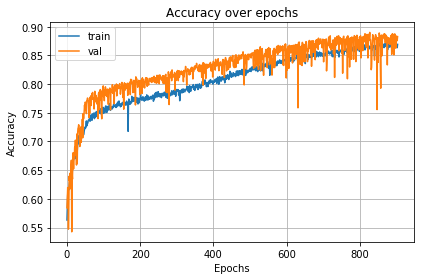

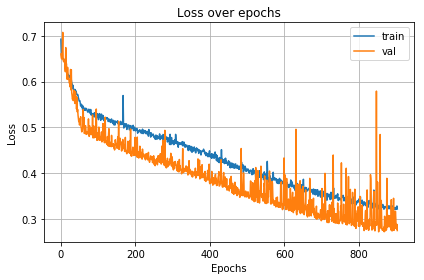

In [20]:
import numpy as np
import matplotlib.pyplot as plt

plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='val')
plt.grid(True, which='both', axis='both')

# plt.minorticks_on()
plt.tight_layout()

plt.legend()
plt.show()

plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.grid(True, which='both', axis='both')
plt.tight_layout()
plt.legend()
plt.show()

# # Plot training & validation accuracy values
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()

# # Plot training & validation loss values
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()

In [2]:
from keras.models import load_model

model.save('eeg_eye_state_model_rnn.h5')  # creates a HDF5 file 'my_model.h5'

# model = load_model('eeg_eye_state_model_rnn.h5')


In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score

y_pred = model.predict_classes(X_test)
print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

Precision: 0.854
Recall: 0.877
F1: 0.865


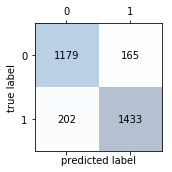

In [23]:
from sklearn.metrics import confusion_matrix

confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=[1, 0])
#print(confmat)
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('predicted label')
plt.ylabel('true label')

plt.tight_layout()
# plt.savefig('./figures/confusion_matrix.png', dpi=300)
plt.show()

ROC AUC: 0.877
Accuracy: 0.877


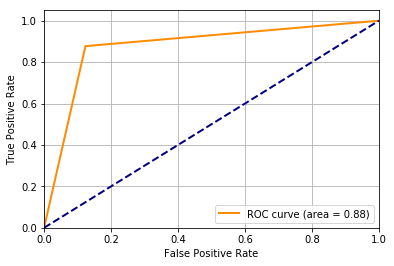

In [24]:
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, auc
print('ROC AUC: %.3f' % roc_auc_score(y_true=y_test, y_score=y_pred))
print('Accuracy: %.3f' % accuracy_score(y_true=y_test, y_pred=y_pred))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 1
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2

plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

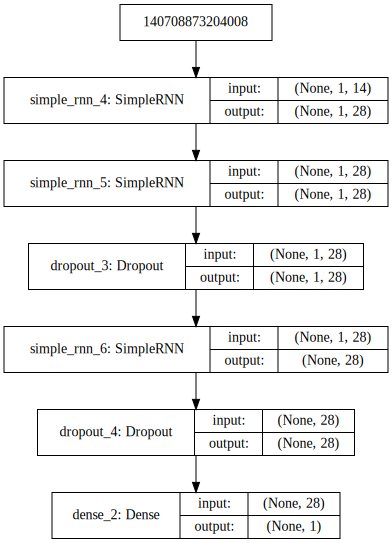

In [5]:
from keras.utils import plot_model
# plot_model(model, to_file='model.png')
plot_model(model, to_file='model_plot.png', show_shapes=False, show_layer_names=False)

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))


In [26]:
from sklearn.metrics import classification_report
target_names = ['eye opened', 'eye closed']
print(classification_report(y_test, y_pred, target_names=target_names, digits=3))

              precision    recall  f1-score   support

  eye opened      0.897     0.876     0.886      1635
  eye closed      0.854     0.877     0.865      1344

   micro avg      0.877     0.877     0.877      2979
   macro avg      0.875     0.877     0.876      2979
weighted avg      0.877     0.877     0.877      2979



Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.80')

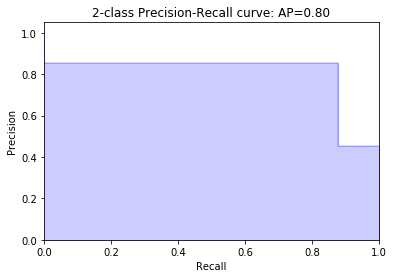

In [27]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_pred)

from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, _ = precision_recall_curve(y_test, y_pred)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

In [28]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_4 (SimpleRNN)     (None, 1, 28)             1204      
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 1, 28)             1596      
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 28)             0         
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 28)                1596      
_________________________________________________________________
dropout_4 (Dropout)          (None, 28)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 29        
Total params: 4,425
Trainable params: 4,425
Non-trainable params: 0
_________________________________________________________________
